# Make LAS file from a striplog

In this recipe we will show how to extract data from petrophysical logs (issue #71)

First, import modules we might need

In [1]:
import matplotlib.pyplot as plt
% matplotlib inline

import numpy as np

import striplog
striplog.__version__

'0.6.1'

## Making a striplog

In [2]:
from striplog import Striplog, Legend
imgfile = "data/images/P-129_280_1935.png"

In [3]:
legend = Legend.default(name='nsdoe')

In [4]:
top = 280
base = 1935

In [5]:
strip = Striplog.from_image(imgfile, top, base, legend=legend)

If we call the plot method on the striplog we get the whole striplog

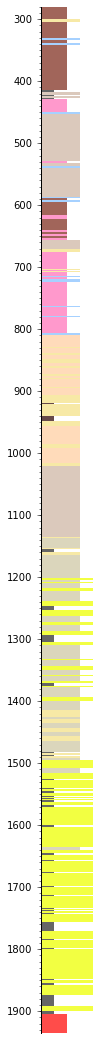

In [6]:
strip.plot(legend, ladder=True)

In [7]:
step = 1.0
liths = strip.to_log(step=step, start=strip.start.middle, legend=legend)
grainsize = strip.to_log(step=step, start=strip.start.middle, legend=legend, legend_field='width')

In [8]:
depth = np.arange(strip.start.middle, strip.stop.middle+step, step)

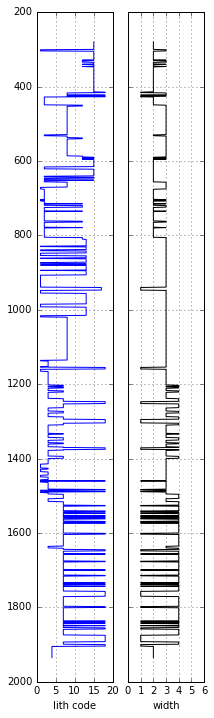

In [9]:
plt.figure(figsize=(3,12))
plt.subplot(121)
plt.plot(liths, depth)
plt.xlim(0,20)
plt.gca().invert_yaxis()
plt.xlabel('lith code')
plt.grid()

plt.subplot(122)
plt.plot(grainsize, depth,'k')
plt.gca().invert_yaxis()
plt.gca().set_yticklabels([])
plt.xlim(0,6)
plt.xlabel('width')
plt.grid()

## Create a well object to get all the header information we want

But anything to do with well-level operations or data happens in `Well`. So to write an entire LAS3 file, we'll need `well.striplogs_to_las3()`. However, this only works reliably if we already have an LAS file containing details like KB and so on. We don't have all this information for these wells, so we will just use our template directly and write some very simple LAS3 files.

In [10]:
from welly import Curve

In [30]:
# curve parameters are things you want associated with the curve in the lasfile
litho_params = {'description': 'Peter Giles lithology',
                'mnemonic':'Lith',
                'start':strip.start.z, 
                'step':step,
                'units':None,
                'null':-999.25}

grain_params = {'description': 'Peter Giles grainsize',
                'mnemonic':'grsz',
                'start':strip.start.z, 
                'step':step,
                'units':None,
                'null':-999.25}

In [31]:
grainCurve = Curve(grainsize, grain_params)
lithCurve = Curve(liths, litho_params)

In [32]:
lithCurve = lithCurve.to_basis(step=0.1524)
grainCurve = grainCurve.to_basis(step=0.1524)
lithCurve

Curve([ 15.,  15.,  15., ...,  nan,  nan,  nan])

## Create a well object so we can add our new curves to it

In [33]:
from welly import Well

In [34]:
# existing LAS file to instantiate a well
lasfile = 'data/las/P-129_out.LAS'

In [35]:
# create a well 
well = Well.from_las(lasfile)

In [36]:
# Add the new curves to the collection of curves in well.data

In [37]:
well.data['grsz'] = grainCurve
well.data['lith'] = lithCurve

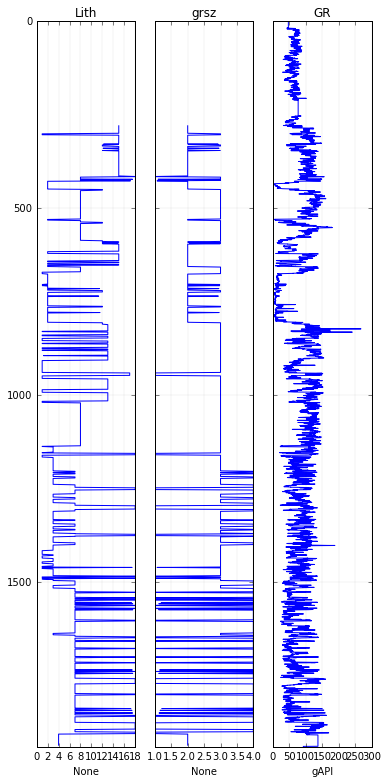

In [38]:
tracks = ['lith','grsz','GR']
well.plot(tracks=tracks)

we'd like to use `welly.to_las()` to export these new curves to las, but first we need to `resample` our two new curves so they have the same number of depth samples as the logs

In [39]:
well.data['lith'] = lithCurve.to_basis_like(well.data['GR'])
well.data['grnsz'] = grainCurve.to_basis_like(well.data['GR'])

In [60]:
keys = ['lith', 'grnsz', 'GR']

In [61]:
well.to_las('data/las/P-140_GR_lith_grnsz.LAS', keys=keys)